In [3]:
import torch
from pathlib import Path
from dataset import GraspDataset

# Create dataset
data_path = Path('data/processed')
dataset = GraspDataset(data_path)

# Get a single sample
sample = dataset[0]

# Print available keys
print("Sample contains the following keys:")
for key in sample.keys():
    print(f"- {key}")

# Print tensor shapes and data types
print("\nTensor shapes and types:")
for key, tensor in sample.items():
    print(f"{key}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Type: {tensor.dtype}")
    print(f"  Device: {tensor.device}")
    if tensor.numel() < 10:  # Only print full tensor if it's small
        print(f"  Values: {tensor}")
    print()

# Basic statistics for numerical tensors
print("\nBasic statistics:")
for key, tensor in sample.items():
    if torch.is_floating_point(tensor):
        print(f"{key}:")
        print(f"  Min: {tensor.min().item():.4f}")
        print(f"  Max: {tensor.max().item():.4f}")
        print(f"  Mean: {tensor.mean().item():.4f}")
        print(f"  Std: {tensor.std().item():.4f}")
        print()


Sample contains the following keys:
- sdf
- grasps
- scores

Tensor shapes and types:
sdf:
  Shape: torch.Size([48, 48, 48])
  Type: torch.float32
  Device: cpu

grasps:
  Shape: torch.Size([480, 7])
  Type: torch.float64
  Device: cpu

scores:
  Shape: torch.Size([480])
  Type: torch.float64
  Device: cpu


Basic statistics:
sdf:
  Min: -1.3418
  Max: 1.3413
  Mean: 0.2726
  Std: 0.5322

grasps:
  Min: -0.5236
  Max: 1.8326
  Mean: 0.1521
  Std: 0.4945

scores:
  Min: -1.5000
  Max: 8.6819
  Mean: 1.6106
  Std: 2.8319



torch.Size([1, 48, 48, 48])
torch.Size([1, 480, 7])
torch.Size([1, 480])
Starting training...
Epoch [1/100], Loss: 10.6625
Epoch [2/100], Loss: 7.6872
Epoch [3/100], Loss: 9.9355
Epoch [4/100], Loss: 14.1840
Epoch [5/100], Loss: 13.0887
Epoch [6/100], Loss: 11.9615
Epoch [7/100], Loss: 11.2790
Epoch [8/100], Loss: 10.7631
Epoch [9/100], Loss: 10.9237
Epoch [10/100], Loss: 10.6405
Epoch [11/100], Loss: 10.6458
Epoch [12/100], Loss: 10.5061
Epoch [13/100], Loss: 10.4114
Epoch [14/100], Loss: 10.3688
Epoch [15/100], Loss: 10.6069
Epoch [16/100], Loss: 10.1761
Epoch [17/100], Loss: 10.1589
Epoch [18/100], Loss: 9.6615
Epoch [19/100], Loss: 9.5654
Epoch [20/100], Loss: 8.6439
Epoch [21/100], Loss: 10.0052
Epoch [22/100], Loss: 8.7277
Epoch [23/100], Loss: 9.3606
Epoch [24/100], Loss: 6.9936
Epoch [25/100], Loss: 9.0768
Epoch [26/100], Loss: 7.3600
Epoch [27/100], Loss: 7.5222
Epoch [28/100], Loss: 6.4334
Epoch [29/100], Loss: 6.3285
Epoch [30/100], Loss: 6.1401
Epoch [31/100], Loss: 5.3150


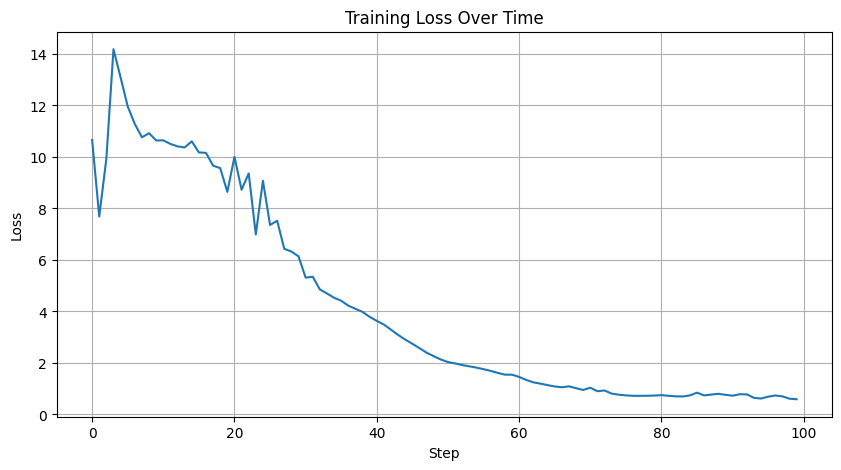

In [7]:
from torch.utils.data import DataLoader
from model import GQEstimator
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GQEstimator().to(device)

# Create dataset and dataloader
data_path = Path('data/processed')
dataset = GraspDataset(data_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Store losses
losses = []

# Overfit on a single batch
fixed_batch = next(iter(dataloader))

# Move data to device and prepare tensors
sdf = fixed_batch['sdf'].float().to(device)  # Shape: [1, C, H, W]
hand_pose = fixed_batch['grasps'].float().to(device)  # Shape: [1, num_grasps, 7]
scores = fixed_batch['scores'].float().to(device)  # Shape: [1, num_grasps]

print(sdf.shape)
print(hand_pose.shape)
print(scores.shape)

print("Starting training...")
for epoch in range(100):
    epoch_loss = 0
        
    # Process each grasp in the batch
    for i in range(50):  # Iterate over grasps
        current_hand_pose = hand_pose[:, i, :]  # Shape: [batch_size, 7]
        current_score = scores[:, i].unsqueeze(1)  # Shape: [batch_size, 1]
        
        # Add channel dimension to SDF for Conv3D
        sdf_with_channel = sdf.unsqueeze(1)  # Shape: [batch_size, 1, D, H, W]
        
        # Forward pass
        pred_quality = model(sdf_with_channel, current_hand_pose)
        
        # Compute loss
        loss = criterion(pred_quality, current_score)
        epoch_loss += loss.item()
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/100], Loss: {epoch_loss/len(dataloader):.4f}')
    losses.append(epoch_loss/len(dataloader))

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()